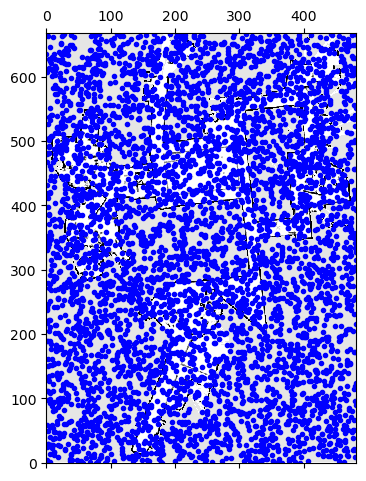

Particles after 0 steps


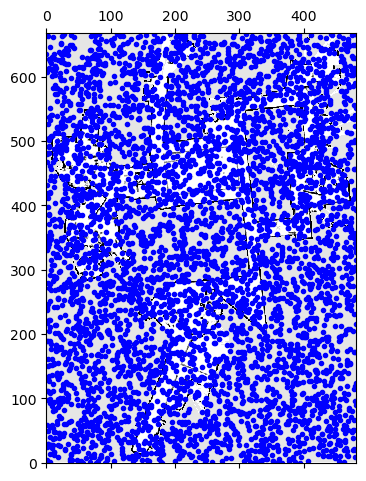

Particles after 100 steps


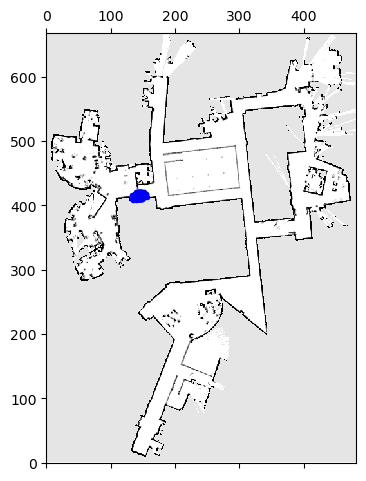

Particles after 200 steps


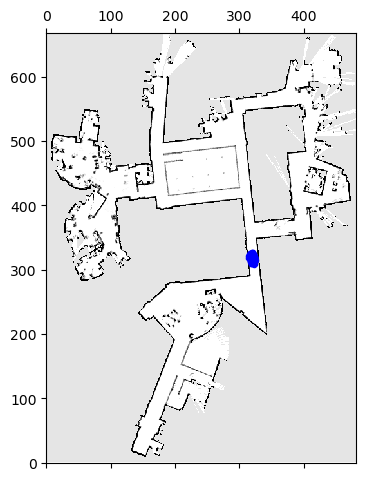

Particles after 300 steps


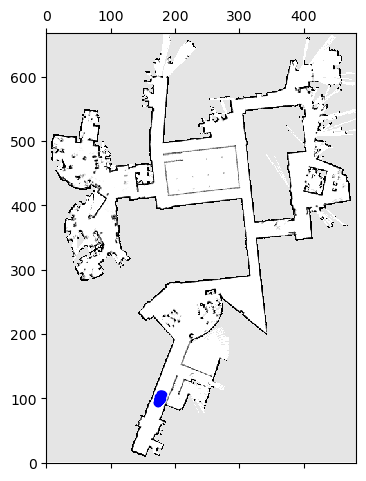

Particles after 400 steps


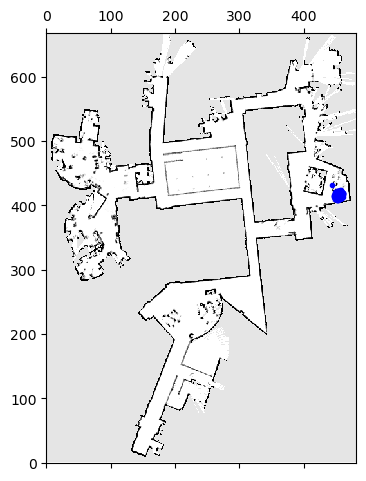

Particles after 500 steps


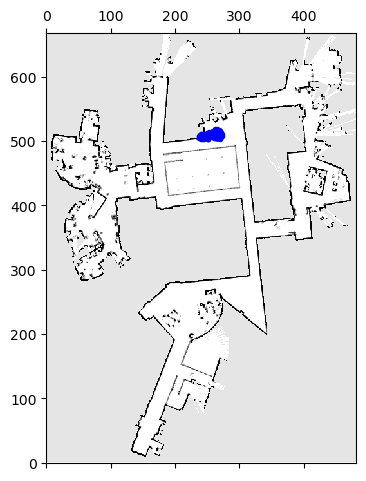

Particles after 600 steps


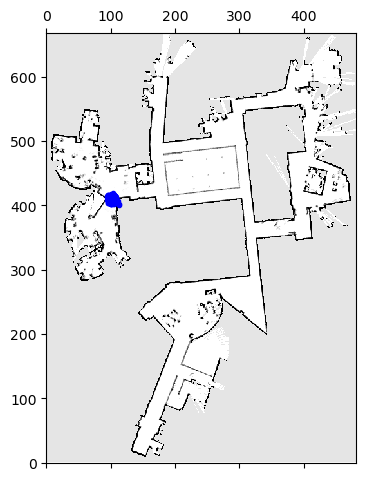

In [3]:
import numpy as np
import pickle
import ex7 as ex
import gif
import matplotlib.pyplot as plt
from ex7 import ranges2cells

def sample(b):
    """Generate a random sample based on a uniform distribution."""
    return np.sqrt(6) * (np.random.uniform(-b, b) + np.random.uniform(-b, b)) / 2

def sample_motion_model_odometry(x_t_minus_1, u_t, alpha=None):
    """
    Sample the next state of the robot based on odometry input and noise parameters.
    
    Parameters:
        x_t_minus_1 (np.array): Previous state [x, y, theta].
        u_t (list): Odometry input [rotation1, translation, rotation2].
        alpha (list): Noise parameters for the motion model.
    
    Returns:
        np.array: The new state [x', y', theta', weight].
    """
    if alpha is None:
        alpha = [0.1, 0.1, 0.1, 0.1]  # Default noise parameters

    rotation1, transformation, rotation2 = u_t

    # Apply noise to the odometry readings
    delta_rot1_hat = rotation1 + sample(alpha[0] * abs(rotation1) + alpha[1] * transformation)
    delta_rot2_hat = rotation2 + sample(alpha[0] * abs(rotation2) + alpha[1] * transformation)
    delta_trans_hat = transformation + sample(alpha[2] * transformation + alpha[3] * (abs(rotation1) + abs(rotation2)))

    # Calculate the new state
    x_prime = x_t_minus_1[0] + delta_trans_hat * np.cos(x_t_minus_1[2] + delta_rot1_hat)
    y_prime = x_t_minus_1[1] + delta_trans_hat * np.sin(x_t_minus_1[2] + delta_rot1_hat)
    theta_prime = (x_t_minus_1[2] + delta_rot1_hat + delta_rot2_hat + np.pi) % (2 * np.pi) - np.pi  # Normalize angle

    # print(f"Sampled new state: x'={x_prime}, y'={y_prime}, theta'={theta_prime}")  # Debugging output

    return np.array([x_prime, y_prime, theta_prime, 1.0])

def compute_weights(x, scan, map, likelihood, map_res):
    """
    Compute the weight of a particle based on the likelihood of the observed scan.
    
    Parameters:
        x (np.array): Current state of the particle.
        scan (np.array): Laser scan data.
        map (np.array): The map of the environment.
        likelihood (np.array): Likelihood map.
        map_res (float): Resolution of the map.
    
    Returns:
        float: The computed weight for the particle.
    """
    weights = 1.0  # Initialize weight

    # Convert scan ranges to map coordinates
    m_points = ranges2cells(scan[1, :].reshape(37, 1), scan[0, :].reshape(37, 1), x, map, map_res)

    # Update weights based on the likelihood of each point
    for i in range(m_points.shape[1]):
        if (0 <= m_points[0, i] < likelihood.shape[1]) and (0 <= m_points[1, i] < likelihood.shape[0]):
            weights *= likelihood[m_points[1, i], m_points[0, i]]
        else:
            weights = 1e-300  # Assign a very low weight if out of bounds
    
    # print(f"Computed weight for particle at {x[:2]}: {weights}")  # Debugging output

    return weights

def resample(particles, weights):
    """
    Resample particles based on their weights using systematic resampling.
    
    Parameters:
        particles (np.array): Array of particles.
        weights (np.array): Corresponding weights of the particles.
    
    Returns:
        np.array: Resampled particles.
    """
    J = particles.shape[0]
    X = np.zeros_like(particles)
    c = weights[0]
    i = 0
    r = np.random.uniform(0, 1 / J)
    
    for j in range(1, J + 1):
        U = r + ((j - 1) / J)
        while U > c:
            i = (i + 1) % J
            c += weights[i]
        X[j - 1] = particles[i]
    
    # print(f"Resampled particles: {X}")  # Debugging output

    return X

@gif.frame
def get_frame(particles, img_map, map_res):
    """
    Create a frame for the GIF showing the current particle distribution.
    
    Parameters:
        particles (np.array): Current particles.
        img_map (np.array): The map image.
        map_res (float): Resolution of the map.
    """
    plt.matshow(img_map, cmap="gray")
    max_y = np.size(img_map, 0) - 1
    xs = np.copy(particles[:, 0]) / map_res
    ys = max_y - np.copy(particles[:, 1]) / map_res
    plt.plot(xs, ys, '.b', markersize=1)  # Plot particles
    plt.xlim(0, np.size(img_map, 1))
    plt.ylim(0, np.size(img_map, 0))

def mc_localization(particles, data, map_res):
    """
    Perform Monte Carlo Localization using the provided particles and data.
    
    Parameters:
        particles (np.array): Initial particles.
        data (dict): Contains odometry and scan data.
        map_res (float): Resolution of the map.
    
    Returns:
        np.array: Final particles after localization.
    """
    likelihood_map = data['likelihood_map']
    gridmap = data["img_map"]
    frames = []
    num_particles = particles.shape[0]
    alpha = np.array([0.1, 0.1, 0.1, 0.1])
    
    for k in range(len(data['odom'])):
        if k % 100 == 0:
            print("Particles after", k, "steps")
            ex.plot_particles(particles, gridmap, map_res)
        
        weights = np.zeros(num_particles)
        U_t = data['odom'][k]
        z = data['z'][k]
        
        for i in range(num_particles):
            particles[i] = sample_motion_model_odometry(particles[i], U_t, alpha)
            weights[i] = compute_weights(particles[i], z, gridmap, likelihood_map, map_res)
        
        weights /= np.sum(weights)  # Normalize weights
        
        particles = resample(particles, weights)  # Resample particles
        frames.append(get_frame(particles, gridmap, map_res))  # Capture frame for GIF
    
    gif.save(frames, "mcl_final.gif", duration=25000)  # Save the GIF
    return particles

# Load dataset
data = pickle.load(open("dataset_mit_csail.p", "rb"))

# Map resolution and number of particles
num_particles = 5000
map_res = 0.1

# Initialize particles uniformly
particles = ex.init_uniform(num_particles, data['img_map'], map_res)

# Plot initial particles
ex.plot_particles(particles, data['img_map'], map_res)

# Run Monte Carlo Localization
particles = mc_localization(particles, data, map_res)